In [ ]:
# import os
# import gzip
# import numpy as np

# Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Leaky ReLU**

In [2]:
def lrelu(x):
    return np.where(x > 0, x, x * 0.01)

def lrelu_der(x):
    dx = np.ones_like(x)
    dx[x <= 0] = 0.01
    return dx

**Softmax**

In [3]:
# see e.g. here: https://deepnotes.io/softmax-crossentropy
def softmax(x):
    """Numerically stable softmax"""
    max_ = np.max(x, axis=-1, keepdims=True)       #                  shape: (n_batch, 1)
    ex = np.exp(x - max_)                          #                  shape: (n_batch, n_out)
    ex_sum = np.sum(ex, axis=-1, keepdims=True)    #                  shape: (n_batch, 1)
    return ex / ex_sum                             # probabilities    shape: (n_batch, n_out)

**Cross Entropy**

Cross entropy for single training example

$$ CE_t = -\sum_{k=1}^{n_\text{out}}y_{tk} \log \hat{y}_{tk} $$

Loss is average CE over mini-batch

$$ J(y, \hat{y}) \ = \ \frac{1}{n_\text{batch}} \sum_{t=1}^{n_{\text{batch}}} CE_t \ = \ - \frac{1}{n_\text{batch}} \sum_{t=1}^{n_{\text{batch}}}  \sum_{k=1}^{n_\text{out}}y_{tk} \log \hat{y}_{tk} $$

In [4]:
def cross_entropy(y, y_hat):
    """CE for any two propbability distributions, averages over batch."""
    result = -np.sum(y * np.log(y_hat), axis=-1)   # cross entropy           shape (n_batch,)
    return np.average(result)                      # average over batch      shape: scalar

In [23]:
def cross_entropy(y, y_hat):
    """CE for one-hot targets y, averages over batch."""
    assert np.alltrue(y.sum(axis=-1) == 1)                          # make sure y is one-hot encoded
    assert np.alltrue(y.max(axis=-1) == 1)
    prob_correct = y_hat[range(len(y_hat)), np.argmax(y, axis=-1)]  # pick y_hat for correct class       (n_batch,)
    return np.average( -np.log(prob_correct) )  

**Accuracy**

In [24]:
def accuracy(y, y_hat):
    result = np.argmax(y, axis=-1) == np.argmax(y_hat, axis=-1)  # shape: (len(y), 1)
    return np.mean(result)                                       # shape: scalar

**Forward Pass**

In [25]:
def forward(x, Wh, bh, Wo, bo):
    z_hid = x @ Wh + bh       # (n_batch, n_hid)
    a_hid = lrelu(z_hid)      # (n_batch, n_hid)
    logits = a_hid @ Wo + bo  # (n_batch, n_out)
    return softmax(logits)    # (n_batch, n_out)

In [26]:
def train_classifier(x_train, y_train, nb_epochs, n_batch, learning_rate, Wh, bh, Wo, bo):
    
    indices = list(range(len(x_train)))
    
    losses = []
    accuracies = []
    
    for epoch in range(nb_epochs):
        np.random.shuffle(indices)
        for i in range(0, len(x_train), n_batch ):
            
            # Pick mini-batch
            i_train = indices[i:i+n_batch]
            x = x_train[i_train]  # (n_batch, n_in)
            y = y_train[i_train]  # (n_batch, n_out)
            
            # Forward
            z_hid = x @ Wh + bh       # (n_batch, n_hid)
            a_hid = lrelu(z_hid)      # (n_batch, n_hid)
            logits = a_hid @ Wo + bo  # (n_batch, n_out)
            y_hat = softmax(logits)   # (n_batch, n_out)

            # Backward
            dJdy = (y_hat - y) / len(x)                 # backprop through CE and softmax  (n_batch, n_out)

            dWo = a_hid.T @ dJdy                        #                                 (same as Wo)
            dbo = np.sum(dJdy, axis=0, keepdims=True)   #                                 (same as bo)
            dJdz = dJdy @ Wo.T * lrelu_der(z_hid)       # backprop into hidden            (n_batch, n_hid)

            dWh = x.T @ dJdz                            #  (same as Wh)
            dbh = np.sum(dJdz, axis=0, keepdims=True)   #  (same as bh)
            
            Wh += -learning_rate * dWh
            bh += -learning_rate * dbh
            Wo += -learning_rate * dWo
            bo += -learning_rate * dbo
            
            loss_train = cross_entropy(y, y_hat)
            acc_train = accuracy(y, y_hat)
            losses.append(loss_train)
            accuracies.append(acc_train)
            
        print(f'epoch {epoch}   loss: {loss_train:.3f}   acc: {acc_train:.3f}')
        #print('epoch:', epoch, '\tloss:', round(loss_train, 2), '\tacc:', acc_train)
        
    return losses, accuracies

# Example 1: Fashion MNIST

Fashion-MNIST dataset, originally taken from here: https://github.com/zalandoresearch/fashion-mnist

**Download and Load**

In [27]:
def download(url, path, md5sum):
    import os
    import urllib
    import hashlib

    folder, file = os.path.split(path)
    if folder != '':
        os.makedirs(folder, exist_ok=True)
    if not os.path.isfile(path):
        print('Downloading', path, '...')
        urllib.request.urlretrieve(url, path)
        assert hashlib.md5(open(path, 'rb').read()).hexdigest() == md5sum
    else:
        print('Already Exists:', file)

In [28]:
download('https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz',
        path='fashion-mnist/t10k-images-idx3-ubyte.gz', md5sum='bef4ecab320f06d8554ea6380940ec79')
download('https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz',
        path='fashion-mnist/t10k-labels-idx1-ubyte.gz', md5sum='bb300cfdad3c16e7a12a480ee83cd310')
download('https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz',
        path='fashion-mnist/train-images-idx3-ubyte.gz', md5sum='8d4fb7e6c68d591d4c3dfef9ec88bf0d')
download('https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz',
        path='fashion-mnist/train-labels-idx1-ubyte.gz', md5sum='25c81989df183df01b3e8a0aad5dffbe')
print('All Done')

Already Exists: t10k-images-idx3-ubyte.gz
Already Exists: t10k-labels-idx1-ubyte.gz
Already Exists: train-images-idx3-ubyte.gz
Already Exists: train-labels-idx1-ubyte.gz
All Done


In [29]:
# This function was obtained from: https://github.com/zalandoresearch/fashion-mnist
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

In [30]:
x_train_raw, y_train_raw = load_mnist('fashion-mnist', kind='train')
x_test_raw, y_test_raw = load_mnist('fashion-mnist', kind='t10k')

**Preprocess**

In [31]:
# Preprocess image dataset
x_train_raw_mean = x_train_raw.mean()  # reuse train mean/std for both train/test
x_train_raw_std = x_train_raw.std()    # (i.e. pretend test dataset doesn't exist)
x_train = (x_train_raw - x_train_raw_mean) / x_train_raw_std
x_test = (x_test_raw - x_train_raw_mean) / x_train_raw_std

print('x_train')
print('mean:', x_train.mean().round(2))
print('std:', x_train.std().round(2))
print('min:', x_train.min().round(2))
print('max:', x_train.max().round(2))
print('shape:', x_train.shape)
print('data:')
print(x_train.round(3))

x_train
mean: -0.0
std: 1.0
min: -0.81
max: 2.02
shape: (60000, 784)
data:
[[-0.81 -0.81 -0.81 ... -0.81 -0.81 -0.81]
 [-0.81 -0.81 -0.81 ... -0.81 -0.81 -0.81]
 [-0.81 -0.81 -0.81 ... -0.81 -0.81 -0.81]
 ...
 [-0.81 -0.81 -0.81 ... -0.81 -0.81 -0.81]
 [-0.81 -0.81 -0.81 ... -0.81 -0.81 -0.81]
 [-0.81 -0.81 -0.81 ... -0.81 -0.81 -0.81]]


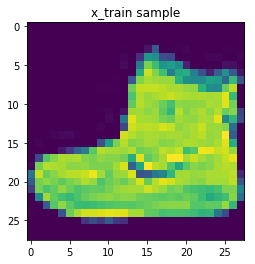

In [32]:
plt.imshow(x_train_raw[0].reshape([28,28]))
plt.title('x_train sample');

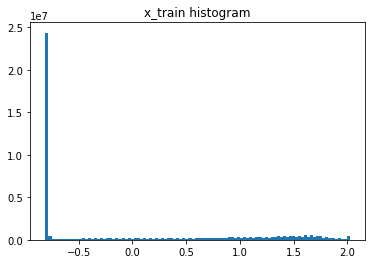

In [33]:
plt.hist(x_train.ravel(), bins=100)
plt.title('x_train histogram');

In [34]:
# Convert labels to one-hot
# https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
y_train = np.eye(N=10)[y_train_raw]
y_test = np.eye(N=10)[y_test_raw]
print('y_train')
print('shape:', y_train.shape)
print(y_train)

y_train
shape: (60000, 10)
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Initialize Neural Network**

In [35]:
n_in = x_train.shape[1]
n_hid = 64
n_out = 10
n_batch = 125
nb_epochs = 20
learning_rate = 0.001

np.random.seed(0)
Wh = np.random.normal(scale=1/(n_in)**.5, size=[n_in, n_hid])
bh = np.zeros(shape=[1, n_hid])
Wo = np.random.normal(scale=1/(n_hid)**.5, size=[n_hid, n_out])
bo = np.zeros(shape=[1, n_out])

In [36]:
losses, accuracies = train_classifier(x_train, y_train, nb_epochs, n_batch, learning_rate, Wh=Wh, bh=bh, Wo=Wo, bo=bo)

epoch 0   loss: 0.958   acc: 0.720
epoch 1   loss: 0.799   acc: 0.728
epoch 2   loss: 0.712   acc: 0.760
epoch 3   loss: 0.659   acc: 0.752
epoch 4   loss: 0.674   acc: 0.768
epoch 5   loss: 0.541   acc: 0.832
epoch 6   loss: 0.668   acc: 0.760
epoch 7   loss: 0.561   acc: 0.784
epoch 8   loss: 0.638   acc: 0.768
epoch 9   loss: 0.564   acc: 0.784
epoch 10   loss: 0.509   acc: 0.848
epoch 11   loss: 0.662   acc: 0.768
epoch 12   loss: 0.541   acc: 0.800
epoch 13   loss: 0.560   acc: 0.824
epoch 14   loss: 0.583   acc: 0.800
epoch 15   loss: 0.464   acc: 0.848
epoch 16   loss: 0.516   acc: 0.840
epoch 17   loss: 0.443   acc: 0.856
epoch 18   loss: 0.476   acc: 0.816
epoch 19   loss: 0.532   acc: 0.808


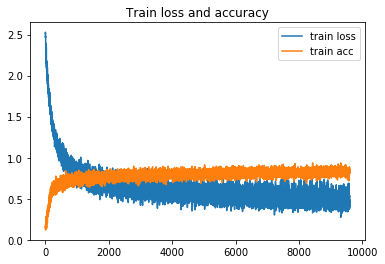

In [48]:
plt.plot(losses, label='train loss')
plt.plot(accuracies, label='train acc')
plt.title('Train loss and accuracy')
plt.legend();

In [49]:
y_hat = forward(x_test, Wh, bh, Wo, bo)
accuracy(y_test, y_hat)

0.8163

# Gradient Check

In [42]:
def numerical_gradient(x, y, Wh, bh, Wo, bo):
    """Calculate gradient numerically"""
    assert Wh.ndim == 2
    assert bh.ndim == 2
    assert bh.shape[0] == 1
    assert Wo.ndim == 2
    assert bo.ndim == 2
    assert bo.shape[0] == 1
    
    eps = 1e-6
    
    # Weights Hidden
    dWh = np.zeros_like(Wh)    
    for r in range(Wh.shape[0]):
        for c in range(Wh.shape[1]):
            Wh_min = Wh.copy()
            Wh_pls = Wh.copy()
            
            Wh_min[r, c] -= eps
            Wh_pls[r, c] += eps
            
            y_hat_pls = forward(x, Wh_pls, bh, Wo, bo)
            y_hat_min = forward(x, Wh_min, bh, Wo, bo)
            
            l_pls = cross_entropy(y, y_hat_pls)
            l_min = cross_entropy(y, y_hat_min)

            dWh[r, c] = (l_pls - l_min) / (eps * 2)
            
    # Biases Hidden
    dbh = np.zeros_like(bh)
    for c in range(bh.shape[1]):
        bh_min = bh.copy()
        bh_pls = bh.copy()
        
        bh_min[0, c] -= eps
        bh_pls[0, c] += eps
            
        y_hat_pls = forward(x, Wh, bh_pls, Wo, bo)
        y_hat_min = forward(x, Wh, bh_min, Wo, bo)
            
        l_pls = cross_entropy(y, y_hat_pls)
        l_min = cross_entropy(y, y_hat_min)

        dbh[0, c] = (l_pls - l_min) / (eps * 2)
        
        
    # Weights Output
    dWo = np.zeros_like(Wo)    
    for r in range(Wo.shape[0]):
        for c in range(Wo.shape[1]):
            Wo_min = Wo.copy()
            Wo_pls = Wo.copy()
            
            Wo_min[r, c] -= eps
            Wo_pls[r, c] += eps
            
            y_hat_pls = forward(x, Wh, bh, Wo_pls, bo)
            y_hat_min = forward(x, Wh, bh, Wo_min, bo)
            
            l_pls = cross_entropy(y, y_hat_pls)
            l_min = cross_entropy(y, y_hat_min)

            dWo[r, c] = (l_pls - l_min) / (eps * 2)
            
    # Biases Output
    dbo = np.zeros_like(bo)
    for c in range(bo.shape[1]):
        bo_min = bo.copy()
        bo_pls = bo.copy()
        
        bo_min[0, c] -= eps
        bo_pls[0, c] += eps
            
        y_hat_pls = forward(x, Wh, bh, Wo, bo_pls)
        y_hat_min = forward(x, Wh, bh, Wo, bo_min)
            
        l_pls = cross_entropy(y, y_hat_pls)
        l_min = cross_entropy(y, y_hat_min)

        dbo[0, c] = (l_pls - l_min) / (eps * 2)
    
    return dWh, dbh, dWo, dbo

In [45]:
def test_gradients():
    n_batch = 100
    n_in = 10
    n_hid = 20
    n_out = 4
    for i in range(100):
        x = np.random.randn(n_batch, n_in)
        y = np.zeros(shape=[n_batch, n_out])
        idx = np.random.randint(0, n_out, size=[n_batch])
        y[range(len(y)), idx] = 1                              # random one-hot encoded matrix
        Wh = np.random.randn(n_in, n_hid)
        bh = np.random.randn(1, n_hid)
        Wo = np.random.randn(n_hid, n_out)
        bo = np.random.randn(1, n_out)

        # Forward
        z_hid = x @ Wh + bh       # (n_batch, n_hid)
        a_hid = lrelu(z_hid)      # (n_batch, n_hid)
        logits = a_hid @ Wo + bo  # (n_batch, n_out)
        y_hat = softmax(logits)   # (n_batch, n_out)
        # Backward
        dJdy = (y_hat - y) / len(x)                 # backprop through CE and softmax  (n_batch, n_out)
        dWo = a_hid.T @ dJdy                        #                                 (same as Wo)
        dbo = np.sum(dJdy, axis=0, keepdims=True)   #                                 (same as bo)
        dJdz = dJdy @ Wo.T * lrelu_der(z_hid)       # backprop into hidden            (n_batch, n_hid)
        dWh = x.T @ dJdz                            #  (same as Wh)
        dbh = np.sum(dJdz, axis=0, keepdims=True)   #  (same as bh)

        ngWh, ngbh, ngWo, ngbo = numerical_gradient(x, y, Wh, bh, Wo, bo)

        assert np.allclose(dbo, ngbo)
        assert np.allclose(dWo, ngWo)
        assert np.allclose(dWh, ngWh)
        assert np.allclose(dbh, ngbh)

In [46]:
test_gradients()